## Regime Changes modeling financial time series data



### 0.Introduction
Regime change(s) in financial time series data refers to a significant shift in the underlying data generating process due to demographic, economic, geo-political, regulatory or other structural change(s). The **damage** of regime change(s) is the distribution of the data is not stationary, which means the mean/intercept, the volatility, the trend, the correlation and the autoregressive or exogenous variables coefficients change over time. This presents a challenge to traditional statistical analysis - recall traditional statistical analysis rely on the assumption of identical distribution. Differentiating these parameters under different regimes is crucial for financial analysis and risk management e.g. assuming the same correlation under normal and stressed times can lead to concentration instead of diversification among different asset types or risks.

More formally, regime changes can be defined as the following:
$$
\overset{\rightharpoonup}{Y_t} = \overset{\rightharpoonup}{c_t} + \overset{\rightharpoonup}{\gamma_t} \cdot t + \overset{\rightharpoonup}{\alpha_t} \cdot \overset{\rightharpoonup}{Y_{t-l}} + \overset{\rightharpoonup}{\beta_t} \cdot \overset{\rightharpoonup}{X_t} + \Sigma_t
$$
,*where* $\overset{\rightharpoonup}{Y_t}$ *is the vector of endogenous variables of interest and* $\overset{\rightharpoonup}{X_t}$ *is the vector exogenous variables,* \\
$\overset{\rightharpoonup}{c_t}$ *- the **mean/intercept**,* \\
$\overset{\rightharpoonup}{\gamma_t}$ *- the **trend coefficient**,* \\
$\overset{\rightharpoonup}{\alpha_t}$ *- the **autoregressive coefficients**,* \\
$\overset{\rightharpoonup}{\beta_t}$ *- the **exogenous variables coefficients**, and* \\

$\Sigma_t$ *the covariance matrix*: ***variance*** and ***correlation***  \\

, of which a subset or all are **time dependent** or change over time, so there is no one underlying distribution of the data.

To the extreme, these parameters can be different from one time period to the next - this is referred to as the **Time-varying parameters model (TVP)**. A common approach of the Time-varying parameters model assumes these parameters follow a Gaussian Random Walk process. A TVP model can be implemented using both the "Frequentist" approach and the Bayesian approach. For example, *statsmodels* package has a TVP model implementation based on the State-Space model (although the Kalman Filter for the measurement error can be considered as a  Bayesian approach).    

An easier and likely more realistic model assumes these parameters stay constant over an episode and then change for the next episode and so on, the number and length of each episode do not need to be fixed - this is referred to as a **Change point (detection) model (CP)**. A Change point detection model involves 1) a metric measuring the differences in these parameters between change points; a popular metric is **CUSUM** diagnostic statistics and 2) an optimization process to decide the "optimal" number of change points. Alternatively, this can be implemented using a Bayesian approach.  

Often though, the different episodes repeat themselves, switching from one regime to another - this is referred to the **Regime switching model (RS)**. Within each regime these parameters stay constant until one regime switches to another, which is often assumed to follow a Markov process. The Markov process is governed by a transition matrix, which is assumed to be constant most of the time, but it can also be time-varying. A Regime switching model can be implemented using either a Frequentist approach, a HMM (Hidden Markov Model) approach or a Bayesian approach.

In this article, we demonstrate how each of the three models above works using a synthetic dataset and a real-world financial data - Gold Price. We focused on the **mean/intercept** and **volatility** parameter, but the same can be extended to other parameters including correlation, autoregressive coefficients and coefficients for exogenous variables. More specifically,
* **Change point model (CP)**: we demonstrate both the Frequentist approach using the ***Ruptures*** package and the Bayesian approach using the ***PYMC*** package.  
*  **Regime switching model (RS)**: we demonstrate both the Frequentist approach using the ***statsmodel*** package, HMM approach using the ***hmmlearn*** package and the Bayesian approach using the ***PYMC*** package.  
 **Time-varying parameters model (TVP)**: we demonstrated the Bayesian approach using the ***PYMC*** package.

This study begins with the introduction, followed by a discussion of the dataset chosen. We then explore the challenge of regime changes, diagnostic tests and illustrate the three models to tackle this challenge. We conclude with a summary of the findings and suggest potential future improvements.


In [ ]:
# !pip install pymc-experimental
# !pip install ruptures
# !pip install hmmlearn

In [ ]:
import datetime
import numpy as np
import pandas as pd
# from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sn

from google.colab import drive
drive.mount('/content/drive/')

import yfinance as yf

from sklearn.ensemble import GradientBoostingRegressor
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import breaks_cusumolsresid
# change point detection package
import ruptures
# PYMC package
import pymc as pm
import pymc_experimental as pmx
# from pymc_experimental.marginal_model import MarginalModel
import pytensor.tensor as pt
import arviz as az

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1.Data and EDA
To assess the different diagnostic tests and modeling approaches, we started with a synthetic dataset with changing intercept and volatility.

We then applied these diagnostic tests and modeling approaches to Gold Price data.


#### 1.1 Synthetic Data
The synthetic data is a piecewise stationary normal distribution with four equally spaced phases with different mean/intercept and volatility, as shown below.

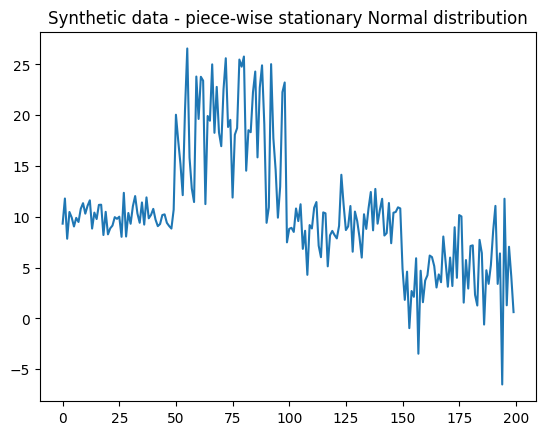

In [ ]:
T=200
data_syn = np.concatenate([np.random.normal(loc=mu,scale=vol,size=round(T/4)) for mu,vol in zip([10,20,10,5],[1,5,2,4])])
# data_syn = np.concatenate([np.random.normal(loc=mu,scale=vol,size=round(T/4)) for mu,vol in zip([0,0,0,0],[1,5,2,4])])
plt.plot(data_syn)
plt.title('Synthetic data - piece-wise stationary Normal distribution');

#### 1.2 Gold Price Data
We selected weekly Gold price data (2006-2024) from Yahoo Finance and relevant data such as S&P500 index, US Dollar Index, Crude oil price, Treasury yield (5 year) and VIX. It is shown in the first chart below, Gold price has experienced a couple of different phases since  2006 - increasing to year 2012, dropping to year 2019, increasing again to year 2022, levelling off around 2023 and finally increasing fast in 2024.

We transformed the raw price data to log returns to make the data stationary and remove the trend. It is shown in the chart below, Gold price log return follows different phases of low and high clustered volatilities.

We briefly explored the relationship between Gold log return data with the relevant variables - US Dollar Index seems to be the most relevant using a non-finetuned Gradient Boost model.

[*********************100%***********************]  7 of 7 completed


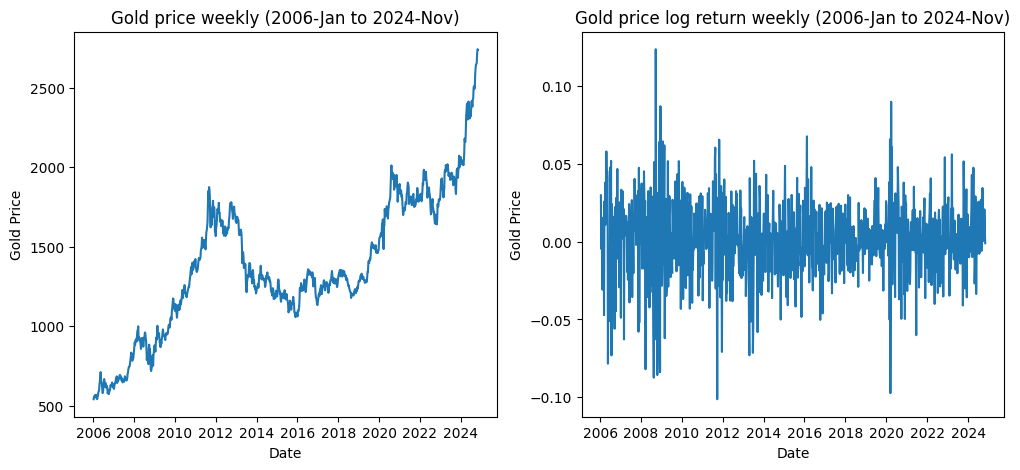

In [ ]:
# importing data related to Gold Price from Yahoo Finance
start = datetime.datetime(2006,1,1)
end = datetime.datetime(2024,11,1)
data=yf.download(['^FVX','^VIX','^SPX','GC=F','CL=F','DX-Y.NYB','BTC-USD'],start,end)['Adj Close']
data.rename(columns={'^FVX':'Treasury Yield 5yr','^VIX':'VIX','^SPX':'SP500','GC=F':'Gold Price','CL=F':'Crude Oil Price','DX-Y.NYB':'US Dollar Index','BTC=USD':'Bitcoin'},inplace=True)
data=data[['Gold Price','US Dollar Index','Crude Oil Price','Treasury Yield 5yr','SP500','VIX']]
data=data.resample('W').last()
# data=data.resample('ME').last()

fig,ax = plt.subplots(1,2,figsize=(12,5))
sn.lineplot(data=data,x=data.index,y='Gold Price',ax=ax[0]).set_title('Gold price weekly (2006-Jan to 2024-Nov)');
data=np.log(data).diff()
data.dropna(inplace=True)
sn.lineplot(data=data,x=data.index,y='Gold Price',ax=ax[1]).set_title('Gold price log return weekly (2006-Jan to 2024-Nov)');

<BarContainer object of 5 artists>

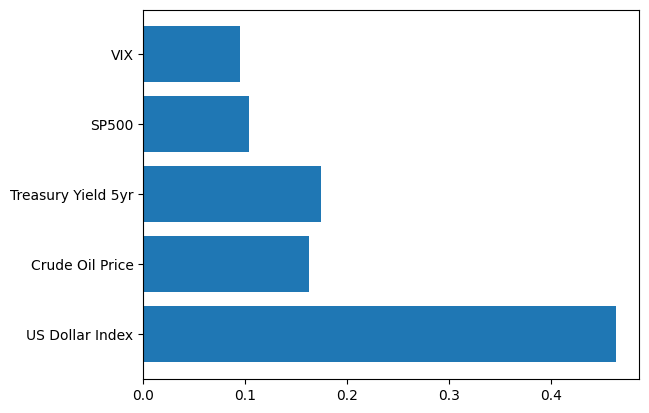

In [ ]:
# exploring the relationship between Gold price log return and relevant variables
m = GradientBoostingRegressor()
m.fit(data.drop(columns=['Gold Price']),data['Gold Price'])
plt.barh(data.drop(columns=['Gold Price']).columns, m.feature_importances_)

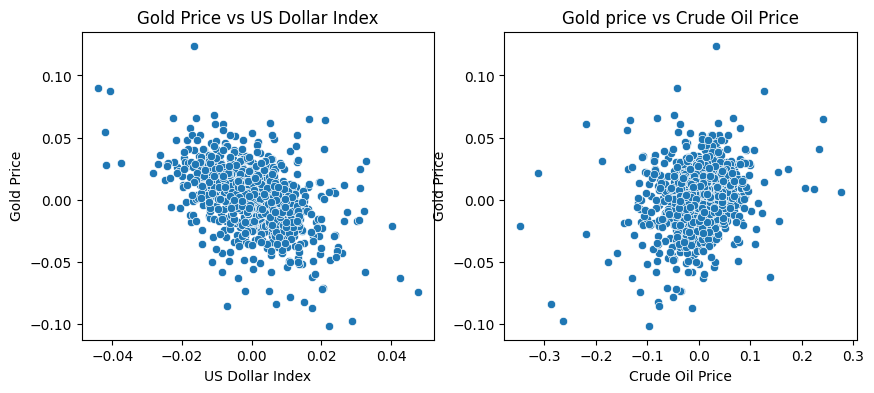

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sn.scatterplot(data=data[['Gold Price','US Dollar Index']],x='US Dollar Index',y='Gold Price',ax=ax[0]).set_title('Gold Price vs US Dollar Index')
sn.scatterplot(data=data[['Gold Price','Crude Oil Price']],x='Crude Oil Price',y='Gold Price',ax=ax[1]).set_title('Gold price vs Crude Oil Price');

### 2.Damages
As discussed in the introduction, with regime change(s) the underlying distribution of the financial data is not stationary and as a result we can not use traditional statistical analysis to estimate the parameters:
* **mean**
* **trend**
* **volatility**
* **correlation**
* **autoregressive coefficients**
* **coefficients for exogenous variables**

Not differentiating these parameters under different regimes can lead to misleading or even disastrous events e.g. treating correlations the same under normal and stressed regimes the same could lead to concentration risk in stressed times instead of diversification which works fine in normal times.  

As shown in the charts above, the distribution of synthetic and real world financial data are both different during different phases, which violates the assumption of identical distribution for most traditional statistical models.  

Regime changes lead to non-stationary distribution, which can be confused with unit-root issue. As shown below, the synthetic data is identified as having **unit-root** based on ACF and PACF (slow decaying autocorrelations) as well as ADF and KPSS unit-root tests, while the data is actually stationary within each period of time i.e. piecewise stationary.

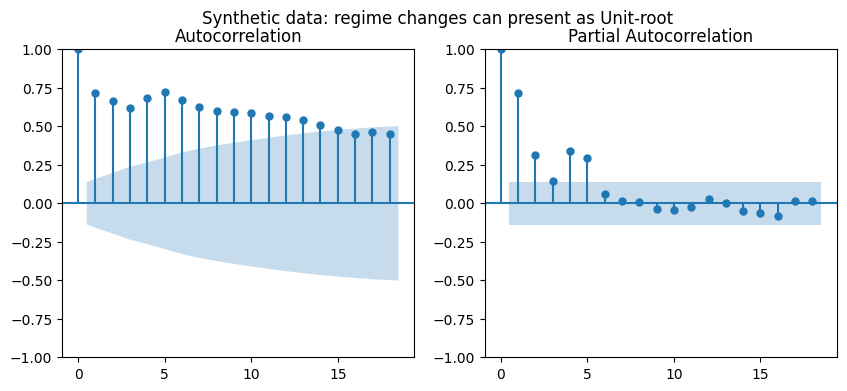

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_acf(data_syn,lags=18, ax=ax[0])
plot_pacf(data_syn,lags=18,ax=ax[1])
plt.suptitle('Synthetic data: regime changes can present as Unit-root');
plt.show()

In [ ]:
res_=adfuller(data_syn)
print(f'Synthetic data: ADF Statistic: {res_[0]:.4f}')
print(f'P-value: {res_[1]:.2%}; Conclusion: Can not reject: Non-stationary!')
res_ = kpss(data_syn)
print(f'Synthetic data: KPSS Statistic: {res_[0]:.4f}')
print(f'P-value: {res_[1]:.2%}; Conclusion: Reject: Non-stationary!\n' );

Synthetic data: ADF Statistic: -1.2362
P-value: 65.78%; Conclusion: Can not reject: Non-stationary!
Synthetic data: KPSS Statistic: 0.9096
P-value: 1.00%; Conclusion: Reject: Non-stationary!



<ipython-input-11-70a26342690d>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res_ = kpss(data_syn)


### 3.Diagnosis and Directions
In this section, we explore different diagnostic tests and modeling approaches to address the challenge posed by regime changes.
1. CUSUM diagnostic test on synthetic and real world financial data
2. Change point detection - Frequentist approach on both synthetic dand real world financial data
3. Change point detection - Bayesian approach on both synthetic dand real world financial data
4. Regime switching model - Frequentist approach on both synthetic dand real world financial data
5. Regime switching model - Bayesian approach on both synthetic dand real world financial data
6. Time-varying parameters model - Bayesian approach on both synthetic dand real world financial data

#### 3.1 Diagnosis: CUSUM test
CUSUM test is a commonly used diagnostic test for regime change(s). The CUSUM test results (p-values lower than 1%) for the synthetic data and Gold price data below showed both data  have regime change(s).

##### Synthetic data

In [ ]:
cusum_test = breaks_cusumolsresid(data_syn-data_syn.mean())
print(f'Synthetic data: CUSUM test (null hypothesis of no regime changes) statistic: {cusum_test[0]:.2f}; p-value: {cusum_test[1]:.2%}. Conclusion: regime change(s) exist!')

Synthetic data: CUSUM test (null hypothesis of no regime changes) statistic: 4.39; p-value: 0.00%. Conclusion: regime change(s) exist!


##### Gold price data

In [ ]:
cusum_test = breaks_cusumolsresid(data['Gold Price'])
print(f'Gold price log return data: CUSUM test (null hypothesis of no regime changes) statistic: {cusum_test[0]:.2f}; p-value: {cusum_test[1]:.2%}. Conclusion: regime change(s) exist!')

Gold price log return data: CUSUM test (null hypothesis of no regime changes) statistic: 2.14; p-value: 0.02%. Conclusion: regime change(s) exist!


#### 3.2 Diagnosis: Change point(s) detection - Frequentist approach
Change point detection methods can be used to diagnose the existence of regime change(s). We chose "ruptures" package to implement the change point detection in a Frequentist way. Please refer to [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0165168419303494?via%3Dihub) for details.

##### Synthetic data
As shown in the charts below (blue and pink color indicates change of regime), the two commonly used methods (Pelt - Penalized Change Point Detection and Binseg - Binary Segmentation) correctly identified the change points in the synthetic data for the most parts.  

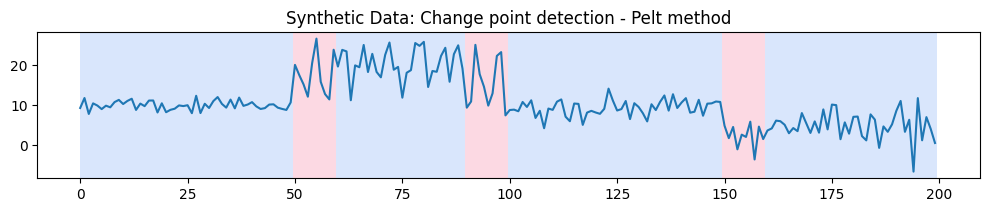

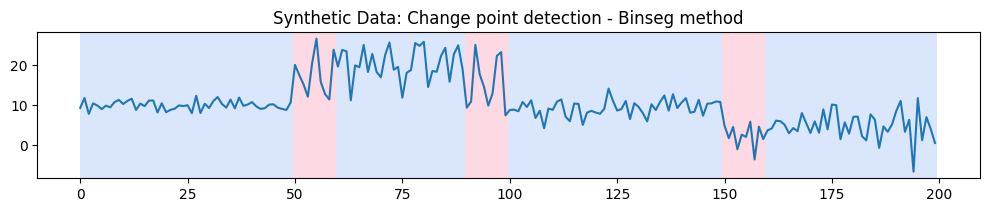

In [ ]:
pen=np.log(T)*data_syn.std()
model_pelt=ruptures.Pelt(model="l2").fit(data_syn)
result = model_pelt.predict(pen=pen)
ruptures.display(data_syn,result)
plt.title("Synthetic Data: Change point detection - Pelt method")
model_binseg=ruptures.Binseg(model="l2").fit(data_syn)
result=model_binseg.predict(pen=pen)
ruptures.display(data_syn,result)
plt.title("Synthetic Data: Change point detection - Binseg method")
plt.show();

##### Gold Price data
For Gold price log return data, however, the change point detection methods can not seem to identify any regime change (there is no change of color from blue to pink). This could be because the log return transformation removed the trend and intercept, leaving mainly the volatility to vary over time - a challenge to the change point detection methods.

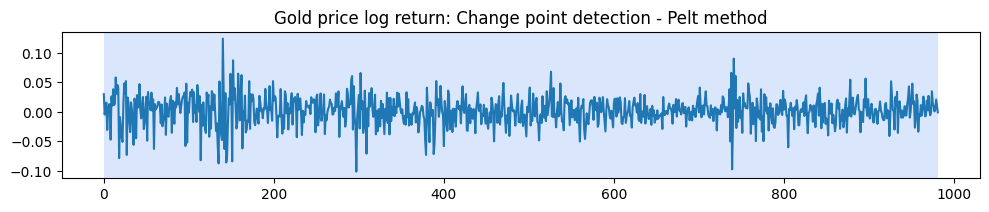

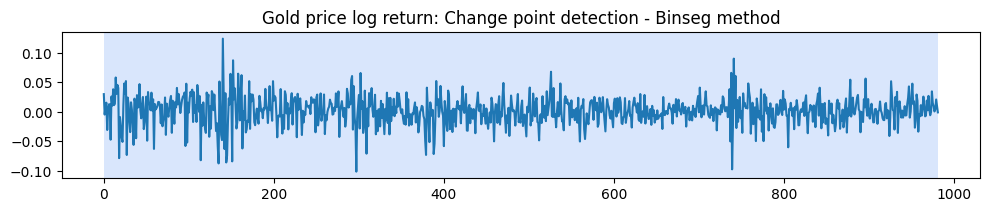

In [ ]:
pen=np.log(len(data))*data['Gold Price'].std()
model_pelt=ruptures.Pelt(model="l2").fit(data['Gold Price'].values)
result = model_pelt.predict(pen=pen)
ruptures.display(data['Gold Price'].values,result)
plt.title("Gold price log return: Change point detection - Pelt method")
model_binseg=ruptures.Binseg(model="l2").fit(data['Gold Price'].values)
result=model_binseg.predict(pen=pen)
ruptures.display(data['Gold Price'].values,result)
plt.title("Gold price log return: Change point detection - Binseg method")
plt.show();

#### 3.3 Diagnosis and Direction: Change point(s) detection - Bayesian approach

Change point detection can be implemented using the Bayesian approach. We chose PYMC package to implement it (for its popularity). As shown below, the posterior distribution of mean and volatility of the synthetic data was correctly identified (although the inferences such as *Rhat* looks terrible). Please refer to [this article](https://ckrapu.github.io/blog/2022/nonparametric-changepoint-model-pymc/) for more details.   

##### Synthetic data
As shown in the last chart below, the Bayesian model identified both the change points for the mean and the volatility, and with a confidence interval, whereas the Frequentist approach above can only detect change points with no insights on the mean and volatility and no confidence interval. Bayesian won!

It is noted that the Bayesian model has a convergence issue, which could be addressed by marginalization of the latent discrete variable(s) - something worth of investigating in the future.

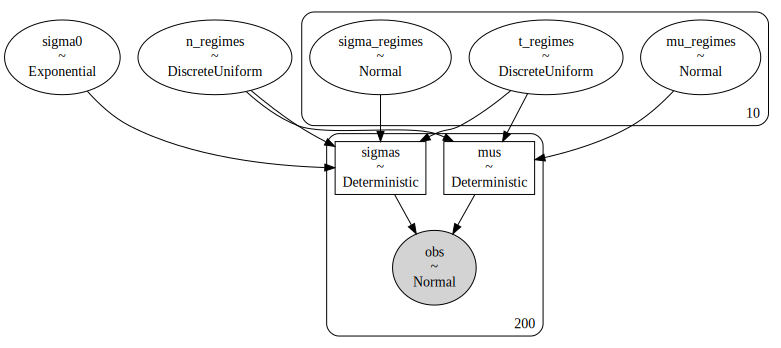

In [ ]:
# Bayesian change point(s) detection
max_n_regimes = 10
tiled_times = np.arange(T)[:,None].repeat(max_n_regimes,axis=1)
with pm.Model() as model_CP:
  n_regimes = pm.DiscreteUniform('n_regimes',0,max_n_regimes)
  t_regimes = pm.DiscreteUniform('t_regimes',1,T-1,shape=max_n_regimes)
  t_regimes_sort = pt.roll(t_regimes.sort(),1)
  t_regimes_sort = pt.set_subtensor(t_regimes_sort[0],0)
  which_regimes = (tiled_times>=t_regimes_sort[None,:].repeat(T,axis=0))

  mu_regimes = pm.Normal('mu_regimes',mu=0,sigma=1,shape=max_n_regimes)
  mus = pm.Deterministic('mus',pt.sum(mu_regimes[:n_regimes] * which_regimes[:,:n_regimes],axis=1))
  sigma0 = pm.Exponential('sigma0',1)
  sigma_regimes = pm.Normal('sigma_regimes',0,1,shape=max_n_regimes)
  sigmas = pm.Deterministic('sigmas',pt.exp(pt.sum(sigma_regimes[:n_regimes] * which_regimes[:,:n_regimes], axis=1)) * sigma0)

  obs = pm.Normal('obs',mu=mus, sigma = sigmas, observed=data_syn)
model_CP.to_graphviz()

In [ ]:
# MCMC simulation
# with model_CP:
#   trace_CP = pm.sample(5000)

In [ ]:
# trace_CP.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_CP.nc")
trace_CP=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_CP.nc")

In [ ]:
# inference
trace_mus=az.summary(trace_CP,var_names=['mus'])
trace_sigmas=az.summary(trace_CP,var_names=['sigmas'])
data_mu=pd.DataFrame(trace_mus.values,columns=trace_mus.columns)
data_sigma=pd.DataFrame(trace_sigmas.values,columns=trace_sigmas.columns)

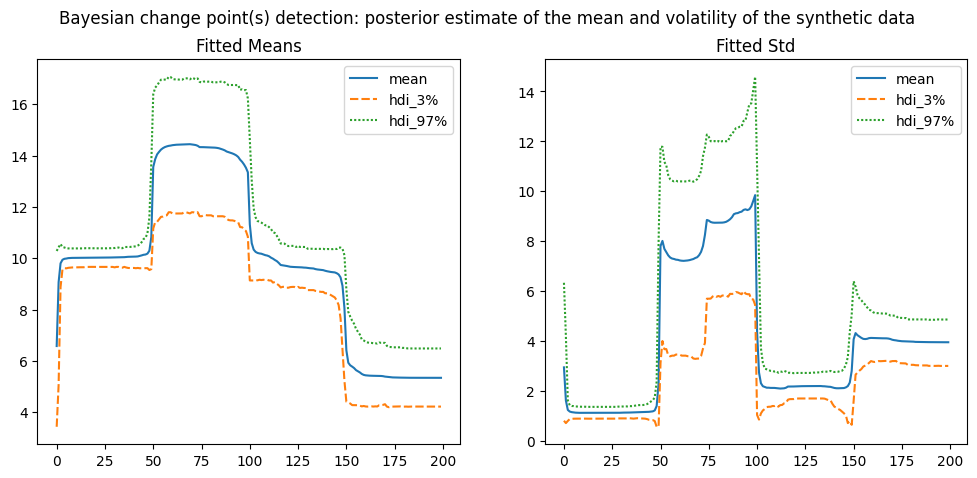

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sn.lineplot(data=data_mu[['mean','hdi_3%','hdi_97%']],ax=ax[0]).set_title("Fitted Means")
sn.lineplot(data=data_sigma[['mean','hdi_3%','hdi_97%']],ax=ax[1]).set_title("Fitted Std")
plt.legend()
plt.suptitle('Bayesian change point(s) detection: posterior estimate of the mean and volatility of the synthetic data');
plt.show()

In [ ]:
# az.summary(trace_CP,var_names=['n_regimes','t_regimes'])
# ToDo: haven't figured out how to implement marginalization; marginalization of discrete latent variables, such as n_regimes can improve the sampling efficency and stability of inference
# with pmx.MarginalModel() as model_marginal:
#   n_regimes = pm.DiscreteUniform('n_regimes',0,max_n_regimes)
#   t_regimes = pm.DiscreteUniform('t_regimes',1,T-1,shape=max_n_regimes)
#   t_regimes_sort = pt.roll(t_regimes.sort(),1)
#   t_regimes_sort = pt.set_subtensor(t_regimes_sort[0],0)
#   which_regimes = (tiled_times>=t_regimes_sort[None,:].repeat(T,axis=0))

#   mu_regimes = pm.Normal('mu_regimes',mu=0,sigma=1,shape=max_n_regimes)
#   mus = pt.sum(mu_regimes[:n_regimes] * which_regimes[:,:n_regimes],axis=1)
#   sigma0 = pm.Exponential('sigma0',1)
#   sigma_regimes = pm.Normal('sigma_regimes',0,1,shape=max_n_regimes)
#   sigmas = pt.exp(pt.sum(sigma_regimes[:n_regimes] * which_regimes[:,:n_regimes], axis=1))

#   obs = pm.Normal('obs',mu=mus, sigma = sigmas*sigma0, observed=data)
# model_marginal.marginalize([n_regimes])
# model_marginal.to_graphviz()

##### Gold price data
For Gold price log return, the Bayesian approach can not seem to identify any change points, which is consistent with the Frequentist approach above.

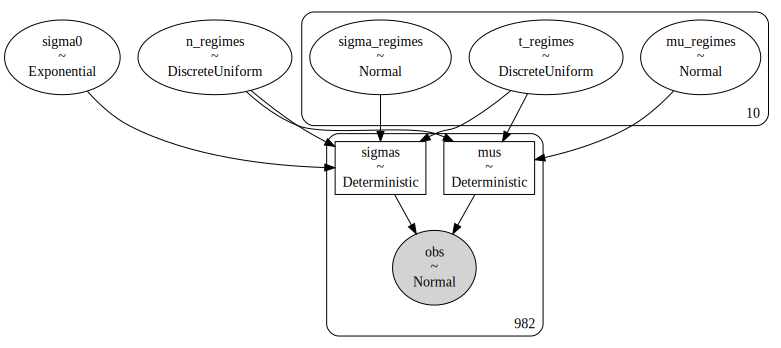

In [ ]:
# Bayesian change point(s) detection
max_n_regimes = 10
tiled_times = np.arange(len(data))[:,None].repeat(max_n_regimes,axis=1)
with pm.Model() as model_CP_gold:
  n_regimes = pm.DiscreteUniform('n_regimes',0,max_n_regimes)
  t_regimes = pm.DiscreteUniform('t_regimes',1,T-1,shape=max_n_regimes)
  t_regimes_sort = pt.roll(t_regimes.sort(),1)
  t_regimes_sort = pt.set_subtensor(t_regimes_sort[0],0)
  which_regimes = (tiled_times>=t_regimes_sort[None,:].repeat(len(data),axis=0))

  mu_regimes = pm.Normal('mu_regimes',mu=0,sigma=1,shape=max_n_regimes)
  mus = pm.Deterministic('mus',pt.sum(mu_regimes[:n_regimes] * which_regimes[:,:n_regimes],axis=1))
  sigma0 = pm.Exponential('sigma0',1)
  sigma_regimes = pm.Normal('sigma_regimes',0,1,shape=max_n_regimes)
  sigmas = pm.Deterministic('sigmas',pt.exp(pt.sum(sigma_regimes[:n_regimes] * which_regimes[:,:n_regimes], axis=1)) * sigma0)

  obs = pm.Normal('obs',mu=mus, sigma = sigmas, observed=data['Gold Price'])
model_CP_gold.to_graphviz()

In [ ]:
# MCMC simulation
# with model_CP_gold:
#   trace_CP_gold = pm.sample(5000)

In [ ]:
# trace_CP_gold.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_CP_gold.nc")
trace_CP_gold=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_CP_gold.nc")

In [ ]:
# inference
trace_mus=az.summary(trace_CP_gold,var_names=['mus'])
trace_sigmas=az.summary(trace_CP_gold,var_names=['sigmas'])
data_mu=pd.DataFrame(trace_mus.values,columns=trace_mus.columns)
data_sigma=pd.DataFrame(trace_sigmas.values,columns=trace_sigmas.columns)

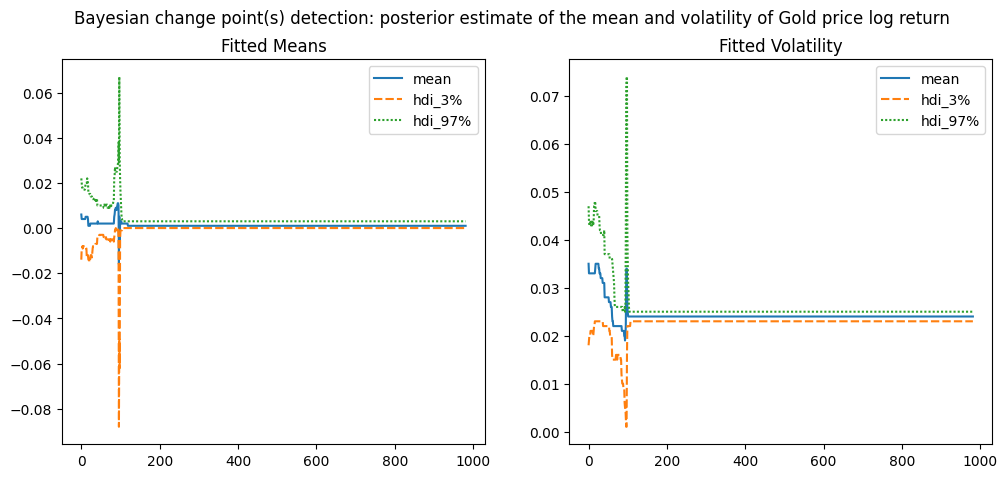

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sn.lineplot(data=data_mu[['mean','hdi_3%','hdi_97%']],ax=ax[0]).set_title("Fitted Means")
sn.lineplot(data=data_sigma[['mean','hdi_3%','hdi_97%']],ax=ax[1]).set_title("Fitted Volatility")
plt.legend()
plt.suptitle('Bayesian change point(s) detection: posterior estimate of the mean and volatility of Gold price log return');
plt.show()

#### 3.4 Direction: Regime switching model - frequentist approach
For Regime switching model, we chose the commonly used statsmodels package.

##### Synthetic data
For synthetic data, the Frequentist Regime switching model (with order 1 autoregressive component) had some convergence issue  causing it unable to robustly identify different (chosen two) regimes. This is shown in the result summary and in the chart plot the smoothed latent variable - probability of being in regime 0.

In [ ]:
model_RS = sm.tsa.MarkovAutoregression(pd.DataFrame({'data_syn':data_syn}),k_regimes=2,order=1,switching_variance=True)
results_RS_syn = model_RS.fit()
print(results_RS_syn.summary())

                         Markov Switching Model Results                         
Dep. Variable:                 data_syn   No. Observations:                  199
Model:             MarkovAutoregression   Log Likelihood                -545.828
Date:                  Sat, 28 Dec 2024   AIC                           1107.656
Time:                          13:57:04   BIC                           1134.002
Sample:                               0   HQIC                          1118.319
                                  - 199                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3526        nan        nan        nan         nan         nan
sigma2        1.6e-23   8.16e-12   1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


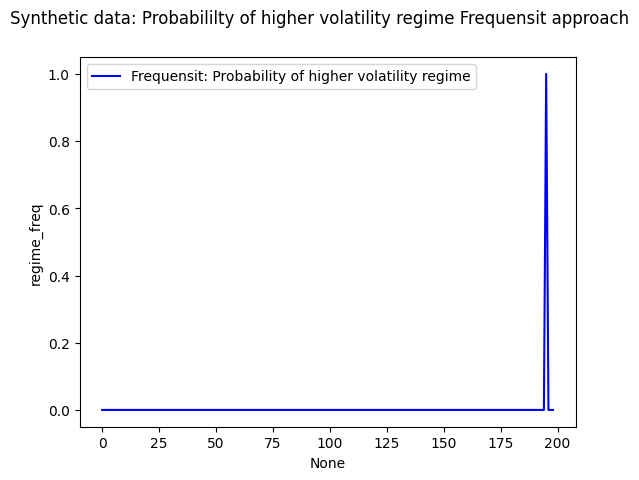

In [ ]:
d_syn=pd.DataFrame({'regime_freq':results_RS_syn.smoothed_marginal_probabilities[0].values})
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime")
plt.suptitle("Synthetic data: Probabililty of higher volatility regime Frequensit approach");

##### Gold price data
For Gold price log return, the Frequentist Regime switching model identified (chosen two) regimes with statistically different means and volatilities, although the autoregressive components are not statistically significant.  

In [ ]:
model_RS = sm.tsa.MarkovAutoregression(data['Gold Price'],k_regimes=2,order=1,switching_variance=True)
results_RS = model_RS.fit()
print(results_RS.summary())

                         Markov Switching Model Results                         
Dep. Variable:               Gold Price   No. Observations:                  981
Model:             MarkovAutoregression   Log Likelihood                2330.391
Date:                  Sat, 28 Dec 2024   AIC                          -4644.782
Time:                          13:57:18   BIC                          -4605.673
Sample:                      01-15-2006   HQIC                         -4629.904
                           - 11-03-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.530      0.011       0.000       0.003
sigma2         0.0004   2.08e-05    

In [ ]:
d_=pd.merge(data.copy(),results_RS.smoothed_marginal_probabilities[0],left_index=True, right_index=True)
d_.rename(columns={0:'regime_freq'},inplace=True);

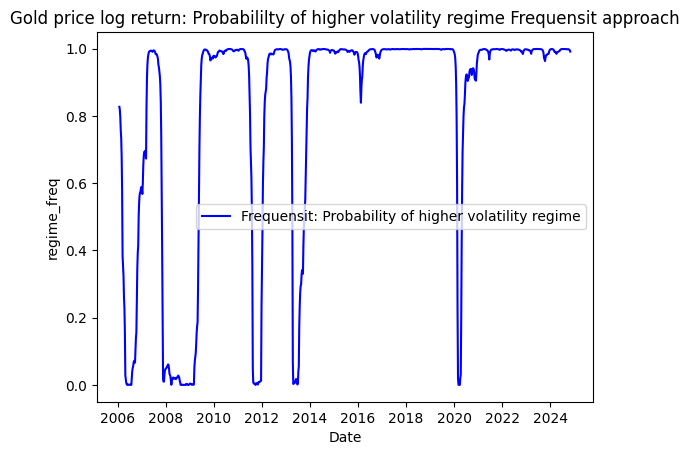

In [ ]:
sn.lineplot(data=d_,x=d_.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime").set_title("Gold price log return: Probabililty of higher volatility regime Frequensit approach");

#### 3.5 Direction: Regime switching model - HMM (Hidden Markov Model) approach
For HMM implementation of the Regime switching model, we chose hmmlearn package.

##### Synthetic data
For synthetic data, the HMM RS model correctly identified the (chosen two) regimes with low and high volatily. This is shown in the last chart comparing the estimated probability of being in regime 0.

In [ ]:
# Define and fit a 2-state HMM
model_HMM = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
model_HMM.fit(data_syn.reshape(-1, 1))

# Predict hidden states (regimes)
d_syn['regime_hmm'] = model_HMM.predict_proba(data_syn.reshape(-1, 1))[1:,1]

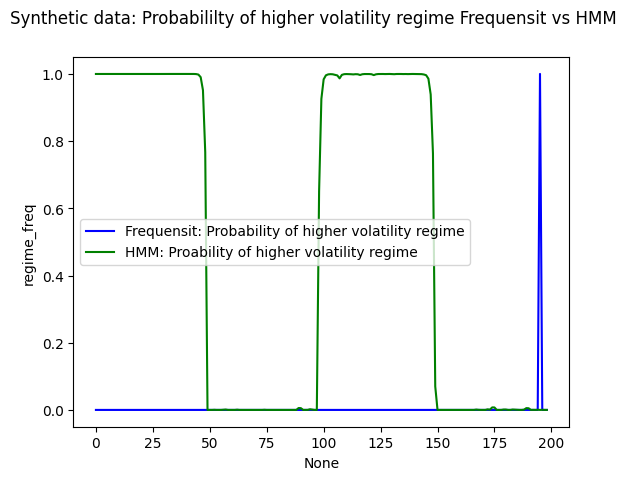

In [ ]:
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime")
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_hmm',color='green',label="HMM: Proability of higher volatility regime")
plt.suptitle("Synthetic data: Probabililty of higher volatility regime Frequensit vs HMM")
plt.legend(loc="best");

##### Gold price data
For Gold price data, the HMM RS model correctly identified the (chosen two) regimes with low and high volatily, consistent with the Frequentist approach. This is shown in the last chart comparing the estimated probability of being in regime 0.

In [ ]:
# Define and fit a 2-state HMM
model_HMM = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
model_HMM.fit(data['Gold Price'].values.reshape(-1, 1))

# Predict hidden states (regimes)
d_['regime_hmm'] = model_HMM.predict_proba(data['Gold Price'].values.reshape(-1,1))[1:,0]

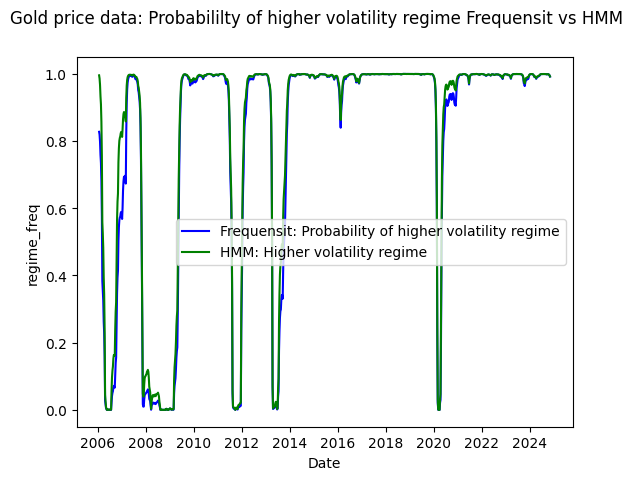

In [ ]:
sn.lineplot(data=d_,x=d_.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime")
sn.lineplot(data=d_,x=d_.index,y='regime_hmm',color='green',label="HMM: Higher volatility regime")
plt.suptitle("Gold price data: Probabililty of higher volatility regime Frequensit vs HMM")
plt.legend(loc="best");

#### 3.6 Direction: Regime switching model - Bayesian approach
For Bayesian implementation of the Regime switching model, we chose PYMC package.

##### Synthetic data
For synthetic data, the Bayesian RS model correctly identified the (chosen two) regimes with low and high volatilies, consistent with the HMM model whereas the Frequentist approach had a challenge to do so. This is shown in the last chart comparing the estimated probability of being in regime 0.

In [ ]:
with pm.Model() as model_MC_syn:
# regime switching volaitlity with AR(1) for mean
    P = pm.Dirichlet("P", a=[1, 10], size=2)
    regime = pmx.DiscreteMarkovChain("regime", P=P, shape=(T,))
    volatility = pm.Normal("volatility",0,1, size=2)
    beta = pm.Normal("beta", mu=0, sigma=0.1, shape=2)
    # mu = pm.AR("mu", beta, sigma=0.1, constant=True, shape=len(data))
    mu = pm.Normal("mu", 0, 1)
    obs = pm.Normal("obs", mu=mu, sigma=pt.exp(volatility[regime]), observed=data_syn)

model_MC_syn.to_graphviz();

/usr/local/lib/python3.10/dist-packages/pymc_experimental/distributions/timeseries.py:169: UserWarning: Initial distribution not specified, defaulting to `Categorical.dist(p=pt.full((k_states, ), 1/k_states), shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [ ]:
# with model_MC_syn:
#     trace_MC_syn = pm.sample(5000)
#     posterior_predictive_MC_syn = pm.sample_posterior_predictive(trace_MC_syn)

In [ ]:
# trace_MC_syn.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_MC_syn.nc")
trace_MC_syn=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_MC_syn.nc")

In [ ]:
az.summary(trace_MC_syn,var_names=['~mu','~regime']);

In [ ]:
d_syn['regime_mc']=1-az.summary(trace_MC_syn,var_names=['regime'])['mean'].values[1:];

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (be

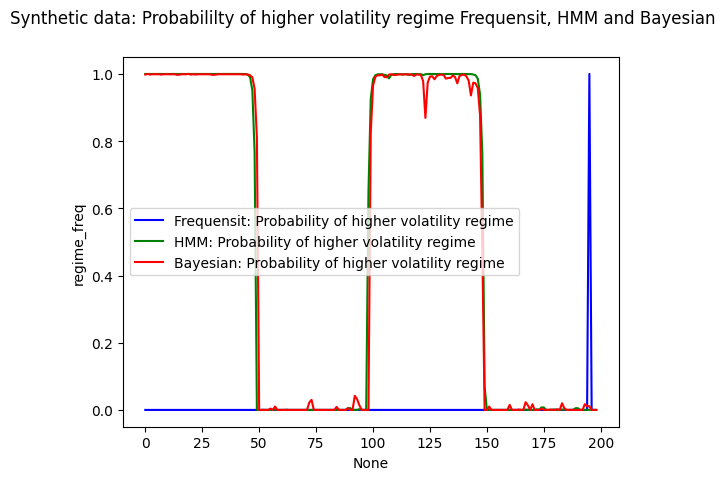

In [ ]:
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime")
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_hmm',color='green',label="HMM: Probability of higher volatility regime")
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_mc',color='red',label="Bayesian: Probability of higher volatility regime")
plt.suptitle("Synthetic data: Probabililty of higher volatility regime Frequensit, HMM and Bayesian");

##### Gold price data
For Gold price log return, the Bayesian RS identified the (chosen two) regimes with low and high volatilities, which is consistent with the Frequentist approach and HMM approach above. This is shown in the last chart below comparing the estimated probability of being in regime 0.

The Bayesian inference results table below showed:
* there is no statistically significant difference in the mean (beta[0] and beta[1]) from the two regimes
* there is statistically significant difference in the volatility (volatility[0] and volatility[1]) from the two regimes
* the transition probability from regime 0 to regime 1 is around 18% while the probability of transitioning from regime 1 to regime 0 is only around 2%



In [ ]:
with pm.Model() as model_MC:
# regime switching volaitlity with AR(1) for mean
    P = pm.Dirichlet("P", a=[1, 10], size=2)
    regime = pmx.DiscreteMarkovChain("regime", P=P, shape=(len(data),))
    volatility = pm.Normal("volatility",0,1, size=2)
    beta = pm.Normal("beta", mu=0, sigma=0.1, shape=2)
    # mu = pm.AR("mu", beta, sigma=0.1, constant=True, shape=len(data))
    mu = pm.Normal("mu", 0, 1)
    obs = pm.Normal("obs", mu=mu, sigma=pt.exp(volatility[regime]), observed=data["Gold Price"])

model_MC.to_graphviz();

/usr/local/lib/python3.10/dist-packages/pymc_experimental/distributions/timeseries.py:169: UserWarning: Initial distribution not specified, defaulting to `Categorical.dist(p=pt.full((k_states, ), 1/k_states), shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [ ]:
# with model_MC:
#     trace_MC = pm.sample(5000)
#     posterior_predictive_MC = pm.sample_posterior_predictive(trace_MC)

In [ ]:
# trace_MC.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_MC.nc")
trace_MC=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_MC.nc")

In [ ]:
az.summary(trace_MC,var_names=['~mu','~regime'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"P[0, 0]",0.817,0.066,0.693,0.930,0.007,0.005,67.0,400.0,1.06
"P[0, 1]",0.183,0.066,0.070,0.307,0.007,0.005,67.0,400.0,1.06
"P[1, 0]",0.020,0.009,0.005,0.037,0.001,0.000,285.0,773.0,1.02
"P[1, 1]",0.980,0.009,0.963,0.995,0.001,0.000,285.0,773.0,1.02
beta[0],0.000,0.099,-0.189,0.183,0.001,0.001,10859.0,7749.0,1.00
beta[1],-0.002,0.100,-0.187,0.190,0.001,0.001,10878.0,7298.0,1.00
volatility[0],-3.120,0.094,-3.299,-2.951,0.008,0.006,122.0,572.0,1.03
volatility[1],-3.940,0.030,-3.999,-3.884,0.001,0.001,462.0,1769.0,1.01


In [ ]:
d_['regime_mc']=az.summary(trace_MC,var_names=['regime'])['mean'].values[1:]
d_.rename(columns={0:'regime'},inplace=True);

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (be

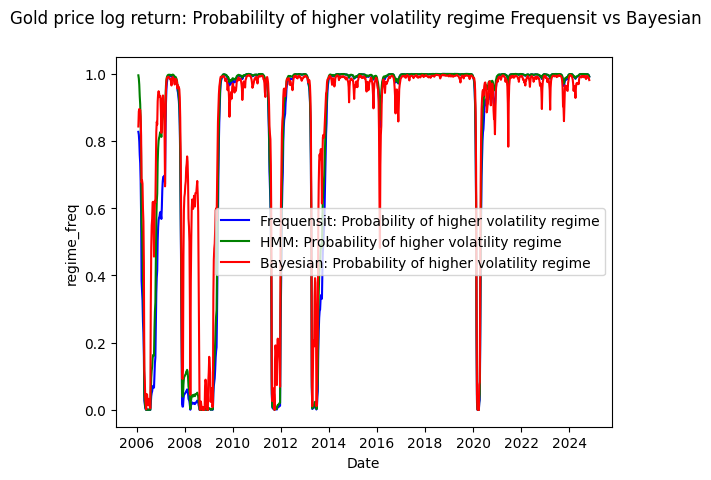

In [ ]:
sn.lineplot(data=d_,x=d_.index,y='regime_freq',color='blue',label="Frequensit: Probability of higher volatility regime")
sn.lineplot(data=d_,x=d_.index,y='regime_hmm',color='green',label="HMM: Probability of higher volatility regime")
sn.lineplot(data=d_,x=d_.index,y='regime_mc',color='red',label="Bayesian: Probability of higher volatility regime")
plt.suptitle("Gold price log return: Probabililty of higher volatility regime Frequensit vs Bayesian");

#### 3.7 Direction: Time varying parameter model - Bayesian approach
For the Bayesian TVP model, we chose PYMC package.

##### Synthetic data
For synthetic data, the Bayesian TVP model estimated the time-varying volatility, which seems to be consistent comparing to the Bayesian RS model latent variable - probability of being in regime 0 shown in the last chart below.

/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


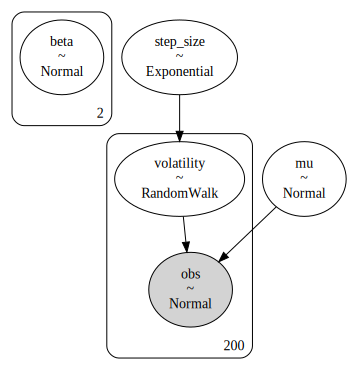

In [ ]:
with pm.Model() as model_TV_syn:
# Time varying volatility with AR(1) for mean
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    # mu = pm.AR("mu", beta, sigma=1, constant=True, shape=len(data))
    mu = pm.Normal("mu", 0, 1)
    step_size = pm.Exponential("step_size", 1)
    volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=T)
    obs = pm.Normal("obs", mu=mu, sigma=pt.exp(volatility), observed=data_syn)

model_TV_syn.to_graphviz()

In [ ]:
# with model_TV_syn:
#     trace_TV_syn = pm.sample(5000)
#     posterior_predictive_TV = pm.sample_posterior_predictive(trace_TV_syn)

In [ ]:
# trace_TV_syn.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_TV_syn.nc")
trace_TV_syn=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_TV_syn.nc")

In [ ]:
az.summary(trace_TV_syn,var_names=['~volatility'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.003,0.993,-1.883,1.893,0.008,0.012,13959.0,6032.0,1.00
beta[1],0.004,1.015,-1.891,1.926,0.009,0.012,13659.0,6185.0,1.00
mu,9.875,0.148,9.579,10.144,0.001,0.001,10827.0,6697.0,1.00
step_size,0.207,0.036,0.143,0.274,0.001,0.001,622.0,1449.0,1.01


In [ ]:
d_syn['volatility_tv']=np.exp(az.summary(trace_TV_syn,var_names=['volatility'])['mean']).values[1:];

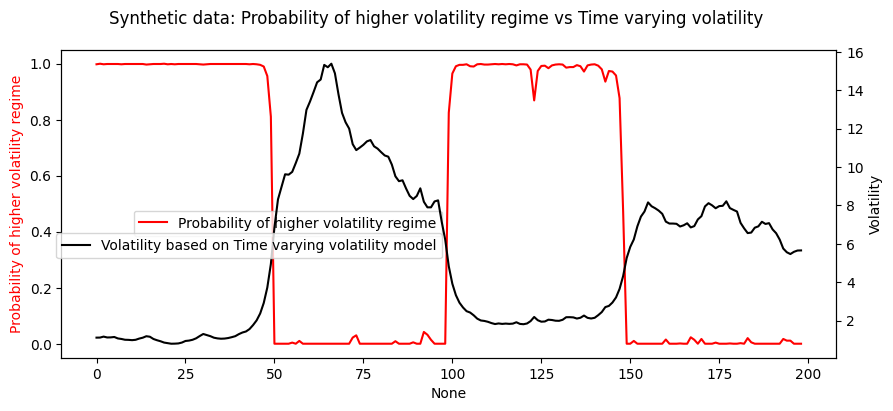

In [ ]:
fig,ax = plt.subplots(figsize=(10,4))
ax1=ax.twinx()
sn.lineplot(data=d_syn,x=d_syn.index,y='regime_mc',color='red',label="Probability of higher volatility regime",ax=ax).set_ylabel("Probability of higher volatility regime",c='red')
ax.legend(bbox_to_anchor=(0.5, 0.5))
sn.lineplot(data=d_syn,x=d_syn.index,y='volatility_tv',color='black',ax=ax1,label="Volatility based on Time varying volatility model").set_ylabel("Volatility",c='black')
ax1.legend(bbox_to_anchor=(0.5, 0.3))
plt.suptitle("Synthetic data: Probability of higher volatility regime vs Time varying volatility");

##### Gold price data
For Gold price log return, the Bayesian TVP model estimated time-varying volatility, which seems to be consistent with the Bayesian RS model above.

/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


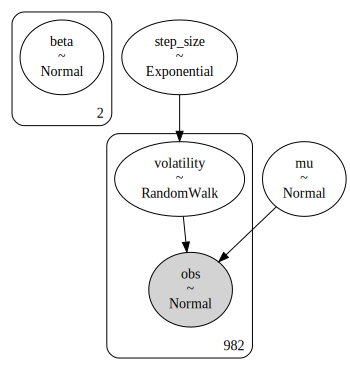

In [ ]:
with pm.Model() as model_TV:
# Time varying volatility with AR(1) for mean
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    # mu = pm.AR("mu", beta, sigma=1, constant=True, shape=len(data))
    mu = pm.Normal("mu", 0, 1)
    step_size = pm.Exponential("step_size", 1)
    volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=len(data))
    obs = pm.Normal("obs", mu=mu, sigma=pt.exp(volatility), observed=data["Gold Price"])

model_TV.to_graphviz()

In [ ]:
# with model_TV:
#     trace_TV = pm.sample(5000)
#     posterior_predictive_TV = pm.sample_posterior_predictive(trace_TV)

In [ ]:
# trace_TV.to_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_TV.nc")
trace_TV=az.from_netcdf("/content/drive/MyDrive/Learning/WQU/M3/3/trace_TV.nc")

In [ ]:
az.summary(trace_TV,var_names=['~volatility'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.016,1.010,-1.933,1.830,0.010,0.012,10081.0,6231.0,1.00
beta[1],0.010,1.010,-1.890,1.904,0.010,0.012,10251.0,6171.0,1.00
mu,0.002,0.001,0.000,0.003,0.000,0.000,10259.0,7069.0,1.00
step_size,0.063,0.011,0.042,0.085,0.002,0.001,34.0,110.0,1.08


In [ ]:
d_['volatility_tv']=np.exp(az.summary(trace_TV,var_names=['volatility'])['mean']).values[1:];

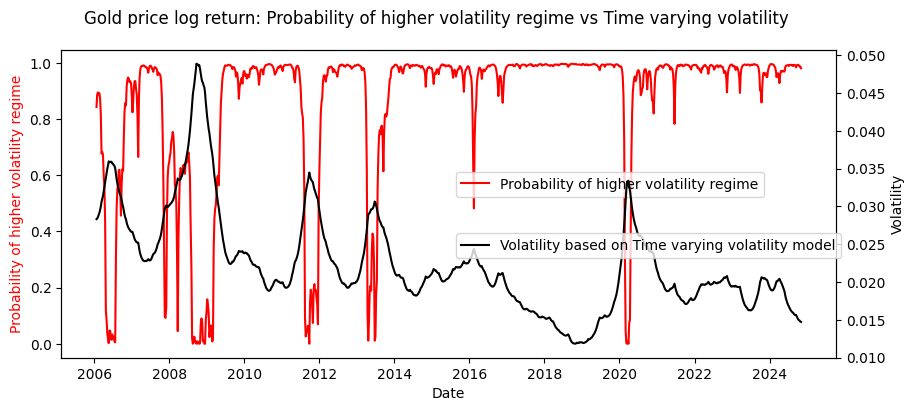

In [ ]:
fig,ax = plt.subplots(figsize=(10,4))
ax1=ax.twinx()
sn.lineplot(data=d_,x=d_.index,y='regime_mc',color='red',label="Probability of higher volatility regime",ax=ax).set_ylabel("Probability of higher volatility regime",c='red')
ax.legend(bbox_to_anchor=(0.5, 0.5))
sn.lineplot(data=d_,x=d_.index,y='volatility_tv',color='black',ax=ax1,label="Volatility based on Time varying volatility model").set_ylabel("Volatility",c='black')
ax1.legend(bbox_to_anchor=(0.5, 0.3))
plt.suptitle("Gold price log return: Probability of higher volatility regime vs Time varying volatility");

### 4.Conclusion and Future improvements
In this study, we explored the use of Change Point detection model (CP), Regime switching model (RS) and Time-varying parameter model (TVP) using both  synthetic data and real-world data. We found the Frequentist CP approach does well on synthetic data (with intercept changes) but not on real world financial data (with only volatility changes but not intercept changes). **The Bayesian approach  for CP, RS and TVP work better or equally well as Frequentist approach or HMM approach in terms of performance and insights but suffers from longer run-time and sensitivity due to priori distribution setting**, which are common challenges for Bayesian approach in general. We focused on the mean/intercept and volatility parameter, but **the same can be extended to other parameters** including correlation, autoregressive coefficients and coefficients for exogenous variables.

There are a few potential areas for future improvements:
* Apply the same approaches to correlation, autoregressive coefficients and coefficients for exogenous variables
* Explore and test the models on other datasets
* Explore statsmodels UnobservedComponents package for TVP implementation   
* Explore fractional differenced log Gold price, may be able to capture some momentum using AR model (1st order difference or log return does not present relationship to lags based on AR model)
* Explore the relationship between Gold price and relevant variables
* Try marginalization of discrete (latent) variables for Bayesian approach to make sampling more stable and efficient.
